## [LG 전자] 자연어 처리 # 3 : 감성분석 - (1)

* 어휘 기반의 감성 분석
* 예상 난이도 ⭐️⭐️

## 강의 복습

강의자료 : 자연어처리 3, AGENDA 02 - 어휘 기반 접근 : Lexicon-based Analysis

## 실습 요약

* 한국어 감성사전을 통해 감성분석을 수행합니다

------

### STEP 0. 환경 구축하기
* 필요한 library들을 import 합니다

In [ ]:
import json
import random
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
#%matplotlib inline #생성한 figure를 notebook에서 볼 수있게 해주는 코드

import gensim
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#check torch version & device
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.10.0+cu111].
device:[cpu].


In [ ]:
! pip install konlpy -q
! pip install glove_python_binary -q

In [ ]:
# set random seed 

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

### STEP 1. 데이터 준비하기
금일 실습에서는 **Naver_shopping**에서 수집된 **리뷰 데이터**를 활용합니다.
* 제품별 후기를 별점과 함께 수집한 데이터
* 데이터셋 출처

  * 1) https://github.com/songys/AwesomeKorean_Data
  * 2) https://github.com/bab2min/corpus/tree/master/sentiment


* 해당 실습에서는 전체 데이터 중 50%인 10만개의 데이터를 사용함 (긍정 : 50000개, 부정 : 50000개)


또한, 금일 실습에서는 공개된 한국어 감성사전을 활용합니다. 
* 데이터셋 출처
  * https://github.com/park1200656/KnuSentiLex





In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/KU-DIC/LG_natural_language_processing_day22

In [ ]:
# 데이터셋 읽기
with open('./LG_natural_language_processing_day22/data/naver_shopping.txt','r',encoding='utf-8') as f:
  data = f.readlines()
# 데이터셋 읽기
with open('./LG_natural_language_processing_day22/data/SentiWord_info.json','r',encoding='utf-8') as f:
  senti_dict = json.load(f)

In [ ]:
# 분석에 사용할 형태로 가공하기
rate = []
label = []
sentence = []
for cur_review in tqdm(data):
  # 평점과 리뷰 문장 분리
  cur_review = cur_review.split('\t')
  # 평점
  rate.append(cur_review[0])
  # 리뷰 문장
  sentence.append(cur_review[1].strip('\n'))
  # 평점 4,5 : Positive, 
  # 평점 1,2 : Negative
  if int(cur_review[0]) >3:
    label.append(1) # positive
  else:
    label.append(-1) # negative

100%|██████████| 200000/200000 [00:00<00:00, 605954.36it/s]


In [ ]:
# 데이터 프레임 형태로 변환하기
df = {
    "rate" : rate,
    "label" : label,
    "sentence" : sentence
}
df = pd.DataFrame(df)
df = df.sample(frac=0.5,replace=False, random_state=42)

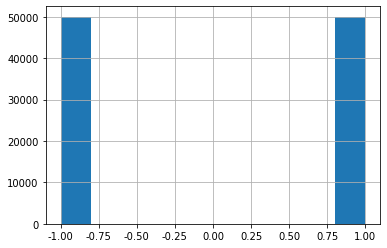

In [ ]:
df['label'].hist()

In [ ]:
df.head()

,rate,label,sentence
119737,2,-1,마감이 안좋아요...실밥도 많고 바느질도 부족한 부분이 몇군데 있네요...교환받기 ...
72272,5,1,깨끗하게 잘 다듬어져 있어요. 맛도좋고요.
158154,4,1,재구매 배송빨라요 길냥이들이 잘먹어요~~ 대용량이라 좋네요~
65426,5,1,제품도 빨리 배송해주시고 꼼꼼하게 잘챙겨주셨어요
30074,5,1,기타 남 멋지고 예뻐요 여러 사은품도 좋아요


In [ ]:
senti_dict[:5]

[{'polarity': '1', 'word': 'ㄱㅅ', 'word_root': 'ㄱ'},
 {'polarity': '1', 'word': 'ㄱㅇㄷ', 'word_root': 'ㄱ'},
 {'polarity': '1', 'word': '가격이 싸다', 'word_root': '가격 싸'},
 {'polarity': '0', 'word': '가까스로', 'word_root': '가까스로'},
 {'polarity': '1', 'word': '가까이 사귀어', 'word_root': '가까이 사귀'}]

In [ ]:
senti_dict = senti_dict[41:] # 특수문자 단어 제외

senti_dictionary = {}
for cur_word in senti_dict:
  polarity = cur_word['polarity']
  word = cur_word['word']
  word_root = cur_word['word_root']

  senti_dictionary[word] = {
      'polarity' : polarity,
      'word_root' : word_root 
  }

### STEP 2. 전처리 진행 (Preprocessing)

In [ ]:
review_sentences = df['sentence'].to_list()

In [ ]:
import re
def preprocess(text):
  text = re.sub('[-=+,#/\?:^$~@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', text)
  text = re.sub('[ㅠㅎㅋ]','', text)
  return text

In [ ]:
normalize_sentence = []
for sentence in tqdm(review_sentences):
  sentence = preprocess(sentence)
  normalize_sentence.append(sentence)

df['normalize_sentence'] = normalize_sentence

100%|██████████| 100000/100000 [00:00<00:00, 244356.24it/s]


### STEP 3. 토큰화 진행 (Tokenization)

In [ ]:
# Okt(Open Korea Text)
from konlpy.tag import Okt  
okt=Okt() 

tokenized_sentence = []
for sent in tqdm(normalize_sentence):
  sent = okt.morphs(sent)
  tokenized_sentence.append(sent)

100%|██████████| 100000/100000 [07:25<00:00, 224.26it/s]


In [ ]:
df['tokenized_sentence'] = tokenized_sentence

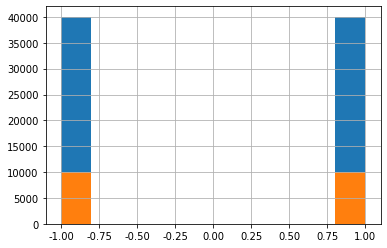

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size =0.2, random_state= 42)
train_df['label'].hist()
test_df['label'].hist()

### STEP 4. 벡터화 진행 (Vectorization)
* 해당 실습에서는 어휘 기반의 감성분석과정에서 벡터화를 수행하지 않음

### STEP 5. 모델 구축하기 (Modeling)


In [ ]:
vocab = senti_dictionary.keys()

train_sentiment_score = []
train_prediction = []
for sent in tqdm(train_df['tokenized_sentence']):
  sentiment_score = 0
  for word in sent:
    if word in senti_dictionary.keys():
      sentiment_score += int(senti_dictionary[word]['polarity'])
  train_sentiment_score.append(sentiment_score)
  if sentiment_score >0:
    train_prediction.append(1)
  elif sentiment_score<0:
    train_prediction.append(-1)
  else:
    train_prediction.append(0)

test_sentiment_score = []
test_prediction = []
for sent in tqdm(test_df['tokenized_sentence']):
  sentiment_score = 0
  for word in sent:
    if word in senti_dictionary.keys():
      sentiment_score += int(senti_dictionary[word]['polarity'])
  test_sentiment_score.append(sentiment_score)
  if sentiment_score >0:
    test_prediction.append(1)
  elif sentiment_score<0:
    test_prediction.append(-1)
  else:
    test_prediction.append(0)


train_df['sentiment_score'] = train_sentiment_score
train_df['prediction'] = train_prediction

test_df['sentiment_score'] = test_sentiment_score
test_df['prediction'] = test_prediction

100%|██████████| 20000/20000 [00:00<00:00, 168841.94it/s]


In [ ]:
test_df[test_df['sentiment_score']==0]

,rate,label,sentence,normalize_sentence,tokenized_sentence,sentiment_score,prediction
135757,1,-1,원래 살려고하던게 품절이여서 주문했는데 두껍고 들뜸현상 있어서 뜯어 버리고 안붙인 ...,원래 살려고하던게 품절이여서 주문했는데 두껍고 들뜸현상 있어서 뜯어 버리고 안붙인 ...,"[원래, 살려고하던게, 품절, 이, 여서, 주문, 했는데, 두껍고, 들뜸, 현상, ...",0.0,0
61220,5,1,재구매 세번째 구매합니다 ㅎ,재구매 세번째 구매합니다,"[재구매, 세번, 째, 구매, 합니다]",0.0,0
48640,4,1,외관은 깨끗합니다. 먹어봐야 알겠죠,외관은 깨끗합니다. 먹어봐야 알겠죠,"[외관, 은, 깨끗합니다, ., 먹어, 봐야, 알겠죠]",0.0,0
22495,2,-1,생각보다별로네여,생각보다별로네여,"[생각, 보다, 별로, 네, 여]",0.0,0
85954,1,-1,"저렴한 가격이라 기대는 안했는데 제품이 참.... 수평 안맞는거야 이해하지만,땜질때...",저렴한 가격이라 기대는 안했는데 제품이 참.... 수평 안맞는거야 이해하지만땜질때문...,"[저렴한, 가격, 이라, 기대는, 안, 했는데, 제품, 이, 참, ...., 수평,...",0.0,0
...,...,...,...,...,...,...,...
121362,2,-1,이것도 뭐 맛이 그닦 수박향만 나요~~,이것도 뭐 맛이 그닦 수박향만 나요,"[이, 것, 도, 뭐, 맛, 이, 그, 닦, 수박, 향, 만, 나요]",0.0,0
191136,1,-1,머리가 자루에서 빠져서 날라가네요 맞아 뒤질뻔 했습니다,머리가 자루에서 빠져서 날라가네요 맞아 뒤질뻔 했습니다,"[머리, 가, 자루, 에서, 빠져서, 날라가네요, 맞아, 뒤질, 뻔, 했습니다]",0.0,0
144573,5,1,"배송도 빠르고, 상품도 맘에들어요^^",배송도 빠르고 상품도 맘에들어요,"[배송, 도, 빠르고, 상품, 도, 맘, 에, 들어요]",0.0,0
36309,2,-1,"다음 이사 갈 땐 이런거 주문 안하려고요. 하기도 힘들고, 만족감도 없고",다음 이사 갈 땐 이런거 주문 안하려고요. 하기도 힘들고 만족감도 없고,"[다음, 이사, 갈, 땐, 이런거, 주문, 안, 하려고요, ., 하기도, 힘들고, ...",0.0,0


In [ ]:
train_df[train_df['sentiment_score']==0]

,rate,label,sentence,normalize_sentence,tokenized_sentence,sentiment_score,prediction
71722,1,-1,옷이 작아요. 불편하고 더워요. 차라리 여성분들이 입기 좋은듯 합니다.,옷이 작아요. 불편하고 더워요. 차라리 여성분들이 입기 좋은듯 합니다.,"[옷, 이, 작아요, ., 불편하고, 더워요, ., 차라리, 여성, 분들, 이, 입...",0.0,0
145982,5,1,재구매 역시나 비밀의 공간을 창출하는덴 이만한 선반이 없어보입니다 정말 맘에 쏙드네...,재구매 역시나 비밀의 공간을 창출하는덴 이만한 선반이 없어보입니다 정말 맘에 쏙드네...,"[재구매, 역시, 나, 비밀, 의, 공간, 을, 창, 출하, 는, 덴, 이만, 한,...",0.0,0
150313,5,1,유리인줄알았는데 연두색뚜껑은 플라스틱이에요,유리인줄알았는데 연두색뚜껑은 플라스틱이에요,"[유리, 인, 줄, 알았는데, 연두색, 뚜껑, 은, 플라스틱, 이에요]",0.0,0
101274,2,-1,포장이 ..완전별로네요.. 물건다흔들려서왓네요 이거만전문으로파실텐데 이해가안가네요,포장이 ..완전별로네요.. 물건다흔들려서왓네요 이거만전문으로파실텐데 이해가안가네요,"[포장, 이, .., 완전, 별로, 네, 요, .., 물건, 다, 흔들려서, 왓, ...",0.0,0
17887,5,1,배송빠르고사은품주신거너무이쁘다고 하심,배송빠르고사은품주신거너무이쁘다고 하심,"[배송, 빠르고, 사은, 품주신, 거너, 무, 이쁘다고, 하, 심]",0.0,0
...,...,...,...,...,...,...,...
133187,5,1,재구매 Wjgndb fje. Rje djsnsb,재구매 Wjgndb fje. Rje djsnsb,"[재구매, Wjgndb, fje, ., Rje, djsnsb]",0.0,0
145813,1,-1,사용에 문제는 없는데 전체적으로 허접합니다 재구매는 안할겁니다,사용에 문제는 없는데 전체적으로 허접합니다 재구매는 안할겁니다,"[사용, 에, 문제, 는, 없는데, 전체, 적, 으로, 허, 접합, 니, 다, 재구...",0.0,0
65137,5,1,아이들 먹이려고 샀는데 구수하고 좋네요 유기농 마루로 정착할것 같은 느낌적인 느낌 ^^,아이들 먹이려고 샀는데 구수하고 좋네요 유기농 마루로 정착할것 같은 느낌적인 느낌,"[아이, 들, 먹이려고, 샀는데, 구수하고, 좋네요, 유기농, 마루, 로, 정착, ...",0.0,0
104667,5,1,원단 부들부들하고 정말 좋아요. 몇 번 입으니 금방 늘어나긴 하지만...그래서 재구...,원단 부들부들하고 정말 좋아요. 몇 번 입으니 금방 늘어나긴 하지만...그래서 재구...,"[원단, 부들부들하고, 정말, 좋아요, ., 몇, 번, 입으니, 금방, 늘어나긴, ...",0.0,0


In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# 성능 평가하기
print('Train data f1 score : ',f1_score(train_df['label'], train_df['prediction'], average='macro'))
print('Train data accuracy score : ',accuracy_score(train_df['label'], train_df['prediction']))
∂
# 성능 평가하기
print('Test data f1 score : ',f1_score(test_df['label'], test_df['prediction'], average='macro'))
print('Test data accuracy score : ',accuracy_score(test_df['label'], test_df['prediction']))

Train data f1 score :  0.2825290014183575
Train data accuracy score :  0.3063625
Test data f1 score :  0.281425984007375
Test data accuracy score :  0.30555
